In [90]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [91]:
data=pd.read_csv("C:/Users/kusha/OneDrive/Desktop/Spring 23/Data Science Projects/AB_Test_Results.csv")

In [92]:
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [93]:
double_variant_count=data.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count    

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [94]:
single_variant_users=(data.groupby("USER_ID")['VARIANT_NAME'].nunique()==1)
single_variant_users=single_variant_users[single_variant_users]


In [95]:
single_variant_users=single_variant_users.to_frame()


In [100]:
len(single_variant_users.index)

4783

In [103]:
data_pcd=data.loc[single_variant_users.index]


In [108]:
data_pcd=data_pcd.drop(['USER_ID'],axis=1)


In [110]:
data_pcd.index

Int64Index([   2,    4,    5,    6,    9,   11,   12,   13,   15,   19,
            ...
            9976, 9980, 9983, 9986, 9989, 9990, 9992, 9993, 9995, 9998],
           dtype='int64', name='USER_ID', length=4783)

In [111]:

data_pcd.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

In [112]:
data_pcd.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

1    4783
Name: VARIANT_NAME, dtype: int64

In [113]:
# we will work on this data
data_pcd

,VARIANT_NAME,REVENUE
USER_ID,,
2,control,0.0
4,variant,0.0
5,variant,0.0
6,control,0.0
9,control,0.0
...,...,...
9990,variant,0.0
9992,variant,0.0
9993,variant,0.0


<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

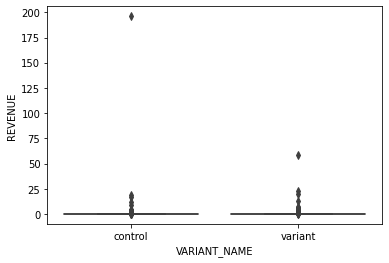

In [114]:
sns.boxplot(x='VARIANT_NAME',y='REVENUE',data=data_pcd)

In [116]:
# there are outliers in data which must be dealt with
data_pcd.sort_values(by='REVENUE',ascending=False).iloc[:10]

,VARIANT_NAME,REVENUE
USER_ID,,
1437,control,196.01
6447,variant,58.63
2482,variant,23.04
5217,variant,19.47
5530,control,18.56
3218,control,17.08
4561,variant,12.99
1468,control,11.98
3740,control,8.66


In [117]:
data_pcd.reset_index(inplace=True)
data_pcd = data_pcd.rename(columns = {'index':'new column name'})

In [120]:
data_pcd.sort_values(by='REVENUE',ascending=False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
685,1437,control,196.01
3091,6447,variant,58.63
1198,2482,variant,23.04
2503,5217,variant,19.47
2652,5530,control,18.56
1536,3218,control,17.08
2202,4561,variant,12.99
699,1468,control,11.98
1815,3740,control,8.66
3414,7151,variant,7.27


In [121]:
# lets remove this outlier
data_pcd=data_pcd[data_pcd['USER_ID']!=1437]

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

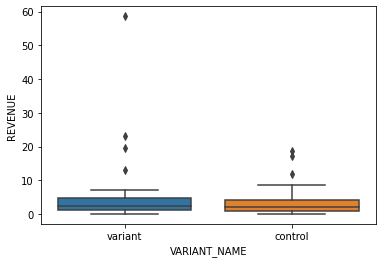

In [123]:
sns.boxplot(x='VARIANT_NAME',y='REVENUE',data=data_pcd[data_pcd['REVENUE']>0])

In [124]:
data_pcd


,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,control,0.0
4,9,control,0.0
...,...,...,...
4778,9990,variant,0.0
4779,9992,variant,0.0
4780,9993,variant,0.0
4781,9995,control,0.0


In [134]:
data_pcd

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,control,0.0
4,9,control,0.0
...,...,...,...
4778,9990,variant,0.0
4779,9992,variant,0.0
4780,9993,variant,0.0
4781,9995,control,0.0


In [132]:
all_stats=data_pcd.groupby(by='VARIANT_NAME').agg({'USER_ID':'nunique','REVENUE':['sum','mean','median','count']})

In [139]:
all_stats

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control         2342  114.34  0.048822    0.0  2342
variant         2440  197.15  0.080799    0.0  2440

In [136]:
orders = all_stats.loc[:, ('REVENUE', 'count')]

In [141]:
orders_per_user=all_stats.loc[:,('REVENUE','count')]/all_stats.loc[:,('USER_ID','nunique')]
orders_per_user

VARIANT_NAME
control    1.0
variant    1.0
dtype: float64

In [142]:
revenue_per_user=all_stats.loc[:,('REVENUE','sum')]/all_stats.loc[:,('USER_ID','nunique')]
revenue_per_user

VARIANT_NAME
control    0.048822
variant    0.080799
dtype: float64

In [143]:
all_stats.loc[:,('per_user','orders')]=orders_per_user
all_stats.loc[:,('per_user','revenue')]=revenue_per_user 
all_stats

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2342  114.34  0.048822    0.0  2342      1.0  0.048822
variant         2440  197.15  0.080799    0.0  2440      1.0  0.080799

In [144]:
# lets see for groups with non zero revenue
paid_stat=data_pcd.loc[data_pcd['REVENUE']!=0].groupby(by='VARIANT_NAME').agg({"USER_ID":'nunique',"REVENUE":['sum','mean','median','count']})

paid_stat

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control           33  114.34  3.464848   2.01    33
variant           35  197.15  5.632857   2.50    35

In [145]:
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

In [146]:
paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           33  114.34  3.464848   2.01    33      1.0  3.464848
variant           35  197.15  5.632857   2.50    35      1.0  5.632857

C:\Users\kusha\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kusha\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kusha\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

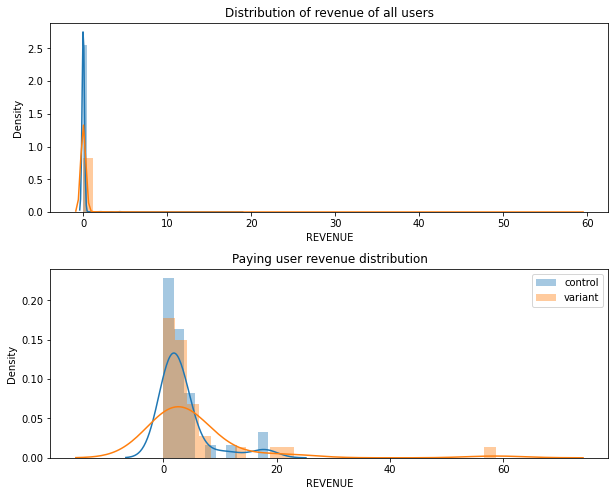

In [156]:
f,axes=plt.subplots(2,figsize=(10,8))
# building graphs of distribution of all users
sns.distplot(data_pcd.loc[data_pcd['VARIANT_NAME']=='control','REVENUE'],ax=axes[0],label='control',kde=True)
sns.distplot(data_pcd.loc[data_pcd['VARIANT_NAME']=='variant','REVENUE'],ax=axes[0],label='variant',kde=True)
axes[0].set_title("Distribution of revenue of all users")


sns.distplot(data_pcd.loc[(data_pcd['VARIANT_NAME'] == 'control') & (data_pcd['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control',kde=True) 
sns.distplot(data_pcd.loc[(data_pcd['VARIANT_NAME'] == 'variant') & (data_pcd['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant',kde=True) 
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)


In [157]:
# lets begin with statistical analysis
shapiro(data_pcd.loc[data_pcd['VARIANT_NAME']=='variant','REVENUE'])

ShapiroResult(statistic=0.0309983491897583, pvalue=0.0)

In [158]:
data_pcd.loc[data_pcd['VARIANT_NAME']=='variant','REVENUE']

1       0.00
2       0.00
7       2.15
8       0.00
9       0.00
        ... 
4771    0.00
4777    0.00
4778    0.00
4779    0.00
4780    0.00
Name: REVENUE, Length: 2440, dtype: float64

In [ ]:
# the null hypothesis about the normal distribution of the data is rejected

In [159]:
data_pcd.loc[data_pcd['VARIANT_NAME']=='control','REVENUE'] 

0       0.0
3       0.0
4       0.0
5       0.0
6       0.0
       ... 
4774    0.0
4775    0.0
4776    0.0
4781    0.0
4782    0.0
Name: REVENUE, Length: 2342, dtype: float64

In [160]:
(data_pcd['REVENUE']==0).value_counts()

True     4714
False      68
Name: REVENUE, dtype: int64

In [161]:
mannwhitneyu(data_pcd.loc[data_pcd['VARIANT_NAME']=='variant','REVENUE'],data_pcd.loc[data_pcd['VARIANT_NAME']=='control','REVENUE'])

MannwhitneyuResult(statistic=2858056.5, pvalue=0.9335547037920324)

In [165]:
# lets see for the only those who pay

mannwhitneyu(data_pcd.loc[(data_pcd['VARIANT_NAME']=='variant') & (data_pcd['REVENUE']>0),'REVENUE'] , data_pcd.loc[(data_pcd['VARIANT_NAME']=='control') & (data_pcd['REVENUE']>0),'REVENUE'])

MannwhitneyuResult(statistic=669.0, pvalue=0.264035239450091)

In [ ]:
# in order to get more complete information about the differences between avg values of the ab test groups, we will use bootstrap.

In [206]:
def get_bootstrap_samples(data,n_samples=1000):
    indices=np.random.randint(0,len(data),(n_samples,len(data)))
    samples=data[indices]
    return samples


def stat_intervals(stat,alpha=0.05):
    boundaries=np.percentile(stat,[100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


In [247]:
control=get_bootstrap_samples(data_pcd.loc[data_pcd['VARIANT_NAME']=='control','REVENUE'].values,1000)

In [248]:
variant=get_bootstrap_samples(data_pcd.loc[data_pcd['VARIANT_NAME']=='variant','REVENUE'].values,1000)

In [249]:
indices=np.random.randint(0,len(data_pcd),(1000,len(data_pcd)))
len(indices[0])

4782

In [250]:
control_paid=get_bootstrap_samples(data_pcd.loc[(data_pcd.VARIANT_NAME=='control') &(data_pcd.REVENUE>0),'REVENUE'].values,1000)
variant_paid=get_bootstrap_samples(data_pcd.loc[(data_pcd.VARIANT_NAME=='variant') &(data_pcd.REVENUE>0),'REVENUE'].values,1000)

In [251]:
# looking at the distribution of means in the ab test group

Text(0.5, 1.0, 'Sample mean distribution of all users')

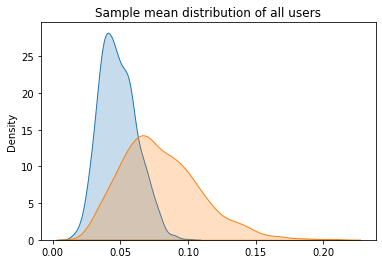

In [252]:
f,ax=plt.subplots()
sns.kdeplot(np.mean(control,axis=1),shade=True,label='control')
sns.kdeplot(np.mean(variant,axis=1),shade=True,label='variant')
plt.title("Sample mean distribution of all users")

Text(0.5, 1.0, 'Sample mean distribution for paying users')

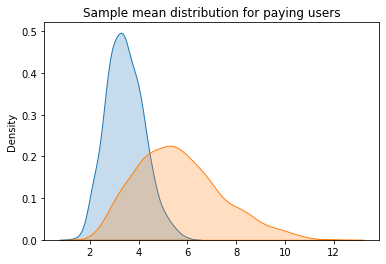

In [253]:
f, ax = plt.subplots()
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

In [256]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim() 
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data 
    return stat_intervals(variant - control) 



IndexError: list index out of range

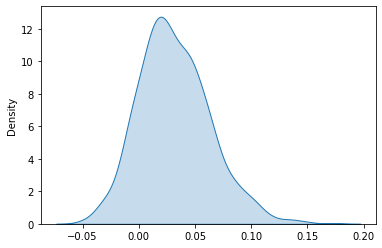

In [257]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1), 
                                     np.mean(control, axis=1),
                                     title='all users') 


                                     

In [238]:
data_exp=data_pcd.loc[data_pcd['VARIANT_NAME']=='control','REVENUE']

In [242]:
data_exp

0       0.0
3       0.0
4       0.0
5       0.0
6       0.0
       ... 
4774    0.0
4775    0.0
4776    0.0
4781    0.0
4782    0.0
Name: REVENUE, Length: 2342, dtype: float64